In [1]:
import numpy  as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import PIL
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Conv2DTranspose,Reshape,BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D,UpSampling2D,Input
)

from PIL import Image as im
from keras.models import Model
from sklearn.model_selection import train_test_split
import cv2


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    m = x_train.shape[0]
    n = x_test.shape[0]
    width = x_train.shape[1]
    height = x_train.shape[2]
    x_train = np.reshape(x_train, (-1,width,height,3))
    x_test = np.reshape(x_test,(-1,width,height,3))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train,y_train,x_test,y_test

In [3]:
x_train,y_train,x_test,y_test = load_data()

170508288/170498071 [==============================] - 5s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
y_train.shape

(50000, 10)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test.shape

(10000, 10)

In [6]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, ch= X_imgs[0].shape
    # Gaussian distribution parameters
    '''mean = 0
    var = 0.9
    sigma = var ** 0.5'''
    
    for X_img in X_imgs:
        gaussian = X_img + 0.1*np.random.normal(loc = 0.0,scale = 1.0,size = (row, col, ch))
        gaussian_img = np.clip(gaussian, 0., 1.)
        '''gaussian_img = cv2.addWeighted(X_img, 0.75, 0.4 * gaussian, 0.25, 0)
        gaussian_img = np.reshape(gaussian_img,(row,col,ch))'''
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [7]:
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

In [8]:
x_train_noisy.shape

(50000, 32, 32, 3)

In [13]:
x_test_noisy.shape

(10000, 32, 32, 3)

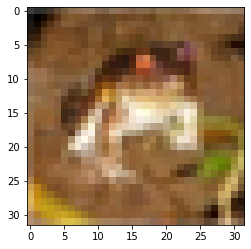

In [9]:
import PIL
from PIL import Image
img = x_train[0]
plt.imshow(img)
plt.show()


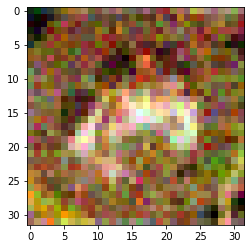

In [10]:
import PIL
from PIL import Image
img = x_train_noisy[0]
#img = np.reshape(img, (28,28))
plt.imshow(img)
plt.show()


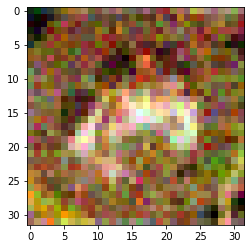

In [11]:
image = x_train_noisy[0]
img = im.fromarray(image, 'RGB')
plt.imshow(image)
plt.show()

In [12]:
def encoder(input_img):

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) 
    conv1_2 = MaxPooling2D((2,2),padding = 'same')(conv1_1)
    conv1_3 = BatchNormalization()(conv1_2)
    

    conv2_1 = Conv2D(32,kernel_size=3,padding='same',activation='relu')(conv1_3)
    conv2_2 = MaxPooling2D((2,2),padding = 'same')(conv2_1)
    conv2_3 = BatchNormalization()(conv2_2)

    conv3_1 = Conv2D(16,kernel_size=3,padding='same',activation='relu')(conv2_3)
    conv3_2 = MaxPooling2D((2,2),padding = 'same')(conv3_1)
    conv3_3 = BatchNormalization()(conv3_2)
    

    #conv4 = Flatten()(conv3_2)
    #conv4 = Dense(1024)(conv4)
    return conv3_3

In [13]:
def decoder(encode):
    
    #conv5_1 = Reshape((4,4,64))(encode)
    #conv5_2 = Conv2DTranspose(32, kernel_size = 3, strides = 2,activation='relu', padding='same')(conv5_1)
    conv4_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(encode)
    conv4_2 = UpSampling2D((2,2))(conv4_1)

    conv5_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4_2)
    conv5_2  = UpSampling2D((2, 2))(conv5_1)

    conv6_1 = Conv2D(16, (3, 3), activation='relu',padding = 'same')(conv5_2)
    conv6_2 = UpSampling2D((2, 2))(conv6_1)
    decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv6_2)

    #conv6_1 = Conv2DTranspose(16, kernel_size = 3, strides = 2,activation='relu', padding='same')(conv5_2)
    #conv6_2 = BatchNormalization()(conv6_1)

    conv7_1 = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation="sigmoid")(conv6_2)
   
    return decode

In [14]:
inChannel = 3
x, y = 32, 32
input_img = Input(shape = (x, y,inChannel))
autoencoder = Model(input_img, decoder(encoder(input_img)))

In [114]:
autoencoder = Model(input_img, decoder(encoder(input_img)))

In [62]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.5,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt)

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0     

In [16]:
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train_noisy,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
train_X.shape

(48000, 28, 28, 1)

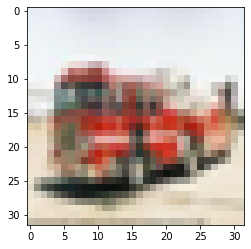

In [81]:
import PIL
from PIL import Image
img = train_ground[4]
#img = np.reshape(img, (28,28))
plt.imshow(img)
plt.show()

In [48]:
valid_X.shape

(10000, 32, 32, 3)

In [49]:
train_ground.shape

(40000, 32, 32, 3)

In [50]:
valid_ground.shape

(10000, 32, 32, 3)

In [17]:
batch_size = 64
epochs = 20

In [18]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.05)
autoencoder.compile(loss='mse', optimizer = 'adam')

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))
autoencoder.save_weights('autoencoder.h5')

Epoch 1/20
625/625 [==============================] - 168s 268ms/step - loss: 0.0158 - val_loss: 0.0119
Epoch 2/20
625/625 [==============================] - 166s 265ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 3/20
625/625 [==============================] - 167s 268ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 4/20
625/625 [==============================] - 166s 266ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 5/20
625/625 [==============================] - 165s 264ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 6/20
625/625 [==============================] - 166s 266ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 7/20
625/625 [==============================] - 166s 266ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 8/20
625/625 [==============================] - 165s 264ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 9/20
625/625 [==============================] - 164s 263ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 10/20
625/625 [==============================] - 167s 267m

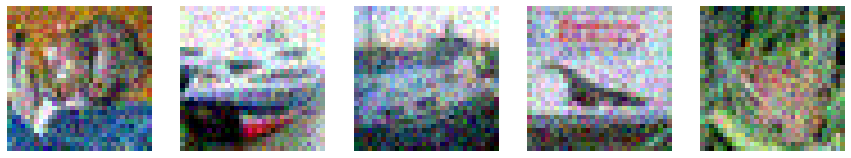

In [20]:
reconstructs = autoencoder.predict(x_test_noisy)
#reconstructs = np.reshape(reconstructs,(-1,28,28))
#x_test_noisy = np.reshape(x_test_noisy,(-1,28,28))
plt.figure(figsize=(15,12))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    '''plt.subplot(2,5,6+i)
    plt.imshow(reconstructs[i])
    plt.axis('off')'''
plt.show()

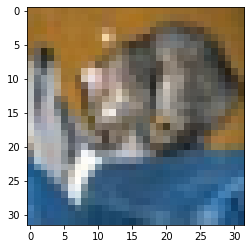

In [24]:
plt.imshow(x_test[0])

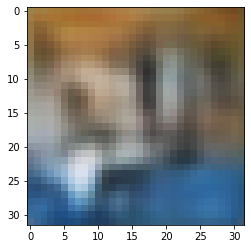

In [25]:
plt.imshow(reconstructs[0])

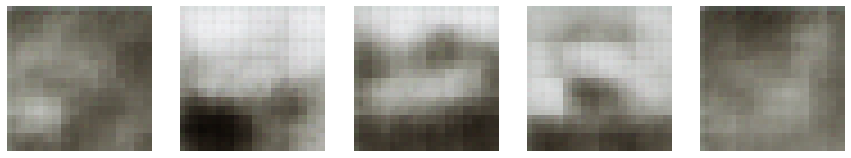

In [76]:
plt.figure(figsize=(15,12))
for i in range(5):
    plt.subplot(2,5,6+i)
    plt.imshow(reconstructs[i])
    plt.axis('off')
plt.show()